# Evolução de Prefeitos Eleitos por Partido e Ideologia

O objetivo do estudo é entender se existe algum movimento similar ao EUA em que grandes cidades tendem a ser mais *progressistas* e cidades menores mais *conservadoras*.

Para isso é analisado o total de votos para prefeito por partido em todos os municípios, municípios >200mil habitantantes e somente capitais.

No cenário nacional é extremamente complicado definir o mapa ideológio dos partidos, assim será utilizado o GPS ideológico a Folha: http://temas.folha.uol.com.br/gps-ideologico/

**Mapa ideológico dos partidos**

- **Esquerda**: PCB / PT,UP,PSOL,PSTU / PCdoB,PCO / PDT,REDE,PSB,PV
- **Centro**: SD,PROS,PTB / PRB,MDB,PP / PSDB,PMN,PMB / CDD,PSD
- **Direita**: DEM,PL,DC,AVT,PSC,PODE / PATRI / NOVO,PRTB,PSL / PTC

Uma alternativa seria utilizar o basômetro do Estadão: https://arte.estadao.com.br/politica/basometro/

Como a categoria **Centro** é muito ampla pelo fisiologismo dos partidos, o autor deste estudo se permite dividir a categoria entre **Centrão** e **Centro Democrático**. Por mais que essa classificação seja subjetiva, é algo que pode ser refinado no futuro.

- **Centrão**: SD,PROS,PTB / PRB,PP / PMN,PMB
- **Centro Dem**: MDB / PSDB / CDD,PSD

**Referências**
- https://www.pewresearch.org/politics/interactives/political-polarization-1994-2017/
- https://news.gallup.com/poll/275792/remained-center-right-ideologically-2019.aspx
- https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.html

**Notas**

- PRN virou PTC em 2000
- PPB virou PP em abril de 2003
- PFL virou DEM em março de 2007
- PTN virou PODE em maio de 2017
- PT DO B virou AVT em setembro de 2017
- PEN virou PATRI em abril de 2018
- PMDB virou MDB em maio de 2018
- PSDC virou DC em maio de 2018
- PPS virou CDD em março de 2019
- PR virou PL em maio de 2019
- PRB virou PR em agosto de 2019
- PST, PHS, PRP, PPL, PAN e PRONA foram extintos

In [1]:
import pandas as pd
import six
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import itertools

from pandas.plotting import table 
from IPython.display import HTML
from unidecode import unidecode

%matplotlib inline

# Ler repositório de votação do TSE (1996-2018)

Dados compilados pelo Brasil.io: https://brasil.io/dataset/eleicoes-brasil/votacoes/

In [2]:
cols = ['ano_eleicao', 'descricao_totalizacao_turno', 
        'codigo_municipio', 'nome_municipio', 'sigla_uf', 'nome_partido', 'numero_partido', 
        'sigla_partido', 'descricao_cargo', 'nome', 'numero_urna', 'numero_zona', 'total_votos']

df_chunk = pd.read_csv('input/2019-04-08/votacao-zona.csv', sep=',', usecols=cols, encoding='latin1', chunksize=1000000)

In [3]:
chunk_list = []

for chunk in df_chunk:  
    chunk_filter = chunk[chunk.descricao_cargo == 'PREFEITO']
    chunk_filter = chunk_filter[chunk_filter.descricao_totalizacao_turno.isin(['ELEITO', 'ELEITO POR QP', 'ELEITO POR MEDIA'])]
    chunk_filter.drop(['descricao_totalizacao_turno', 'descricao_cargo'], axis=1, inplace=True)
    chunk_list.append(chunk_filter)    
df_concat = pd.concat(chunk_list)

C:\Users\guilh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dados parciais 2020

In [4]:
cols = ['codtse','ncand','nome','partido','votabs','situacao','uf']
df_2020 = pd.read_csv('input/prefeitos2020.csv', sep=';', usecols=cols)

In [5]:
df_2020 = df_2020[df_2020.situacao == 'Eleito']
df_2020.drop('situacao', axis=1, inplace=True)
df_2020.columns = ['codigo_municipio', 'numero_urna', 'nome', 'sigla_partido', 'total_votos', 'sigla_uf']

Criar colunas para satisfazer dataset principal

In [6]:
df_2020['ano_eleicao'] = 2020
df_2020['numero_partido'] = df_2020['numero_urna']
df_2020['numero_zona'] = 0

In [7]:
df_temp = pd.read_excel('input/tse_partidos.xlsx')
dict_partidos = pd.Series(df_temp.NOME.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['nome_partido'] = df_2020.numero_partido.map(dict_partidos)

In [8]:
dict_sigla_partidos = pd.Series(df_temp.SIGLA.values, index = df_temp.LEGENDA.values).to_dict()
df_2020['sigla_partido'] = df_2020.numero_partido.map(dict_sigla_partidos)

In [9]:
df_temp = df_concat[['codigo_municipio', 'nome_municipio']].drop_duplicates('codigo_municipio', keep='first').sort_values('codigo_municipio')
dict_municipios = pd.Series(df_temp.nome_municipio.values, index = df_temp.codigo_municipio.values).to_dict()
df_2020['nome_municipio'] = df_2020.codigo_municipio.map(dict_municipios)

In [10]:
df = df_concat.append(df_2020, sort=False)

# Filtrar por ano da eleição

In [11]:
ano_da_eleicao = df.ano_eleicao.unique().tolist()[2:]

Renomear partidos antigos

In [12]:
df.sigla_partido.replace('PRN','PTC', inplace=True)
df.sigla_partido.replace('PPB','PP', inplace=True)
df.sigla_partido.replace('PFL','DEM', inplace=True)
df.sigla_partido.replace('PTN','PODE', inplace=True)
df.sigla_partido.replace('PT DO B','AVT', inplace=True)
df.sigla_partido.replace('PEN','PATRI', inplace=True)
df.sigla_partido.replace('PMDB','MDB', inplace=True)
df.sigla_partido.replace('PSDC','DC', inplace=True)
df.sigla_partido.replace('PPS','CDD', inplace=True)
df.sigla_partido.replace('PR','PL', inplace=True)

# Mapa ideológico dos partidos

In [13]:
mapa_ideologico = {'PCB':'Esquerda',
                    'PT':'Esquerda',
                    'UP':'Esquerda',
                    'PSOL':'Esquerda',
                    'PSTU':'Esquerda',
                    'PC DO B':'Esquerda',
                    'PCO':'Esquerda',
                    'PDT':'Esquerda',
                    'REDE':'Esquerda',
                    'PSB':'Esquerda',
                    'PV':'Esquerda',
                    'SD':'Centrao',
                    'PROS':'Centrao',
                    'PTB':'Centrao',
                    'PRB':'Centrao',
                    'PP':'Centrao',
                    'PMN':'Centrao',
                    'PMB':'Centrao',
                    'MDB':'Centro Dem',
                    'PSDB':'Centro Dem',
                    'CDD':'Centro Dem',
                    'PSD':'Centro Dem',
                    'DEM':'Direita',
                    'PL':'Direita',
                    'DC':'Direita',
                    'AVT':'Direita',
                    'PSC':'Direita',
                    'PODE':'Direita',
                    'PATRI':'Direita',
                    'NOVO':'Direita',
                    'PRTB':'Direita',
                    'PSL':'Direita',
                    'PTC':'Direita',
                    'PST':'Extinto',
                    'PHS':'Extinto',
                    'PRP':'Extinto',
                    'PPL':'Extinto',
                    'PAN':'Extinto',
                    'PRONA':'Extinto'}

In [14]:
df['ideologia'] = df.sigla_partido.map(mapa_ideologico)

# Agrupar resultados por ano e prefeito eleitos por partido

In [15]:
def group_by_year(df):
    res = pd.DataFrame()
    for i, val in enumerate(ano_da_eleicao):
        # Filtrar pelo ano e remover municipios duplicados
        df_by_year = df[df.ano_eleicao == val].drop_duplicates(subset='codigo_municipio', keep='first')

        # Agrupar municipios eleitos por partido
        df_temp = df_by_year.groupby('sigla_partido').count().sort_values('codigo_municipio', ascending=False).iloc[:,0]
        df_temp = df_temp.reset_index(name=val).set_index('sigla_partido')
       
        res = res.join(df_temp, how='outer') 
        
    res.fillna(0,inplace=True)    
    return res

In [16]:
def draw_barchart(year, df, ax, title, textstr):
    res_by_year = df[[year]].dropna().sort_values(by=year, ascending=False).astype(int).head(10)
    ax.clear()
    b = sns.barplot(y=res_by_year.index, x=res_by_year.iloc[:,0], data=res_by_year, palette='plasma', ax=ax)

    plt.title(title, fontsize=25, fontweight='bold')
    plt.xlabel('Municípios', fontsize=15, fontweight='bold')
    plt.ylabel('Partidos', fontsize=15, fontweight='bold')

    b.set_yticks([])
    plt.xticks(fontsize=15)

    dx = res_by_year.iloc[:,0].max() / 100
    pos = range(res_by_year.shape[0])
    for tick in pos:
        ax.text(res_by_year.iloc[tick,0]-dx, pos[tick], res_by_year.index[tick], ha='right', va='center',
                fontsize=25, fontweight='bold', color='w')
        ax.text(res_by_year.iloc[tick,0]+dx, pos[tick], res_by_year.iloc[tick,0], ha='left', va='center',
                fontsize=20, fontweight='bold')
        
    ax.text(0.8, 0.4, str(year), transform=ax.transAxes, color='#777777', size=60, ha='right', weight=800)
        
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.8, 0.1, textstr, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props)

In [17]:
def max_size(column_lenght, max_size=5):
    if column_lenght > max_size:
        size = max_size
    else:
        size = column_lenght
    return size

def draw_subplots(fig, axs, r_esq, r_dir, r_centro_dem, r_centrao, title, legend, labels=5):
    fig.suptitle(title, fontsize=25, fontweight='bold')

    l_esq = sns.lineplot(data=r_esq, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='plasma', ax=axs[0,0])
    l_dir = sns.lineplot(data=r_dir, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='plasma', ax=axs[0,1])
    l_centro_dem = sns.lineplot(data=r_centro_dem, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='plasma', ax=axs[1,0])
    l_centrao = sns.lineplot(data=r_centrao, dashes=False, legend=False, linewidth=5, marker='o',
                     markersize=15, palette='plasma', ax=axs[1,1])

    axs[0,0].set_title('Esquerda', fontsize=15)
    axs[0,1].set_title('Direita', fontsize=15)
    axs[1,0].set_title('Centro Dem.', fontsize=15)
    axs[1,1].set_title('Centrão', fontsize=15)

    # sigla do partido na ultima posicao
    for i in range(max_size(len(r_esq.columns.tolist()),labels)):
        axs[0,0].text(r_esq.index[-1]+.1, r_esq.iloc[-1,i], r_esq.columns[i], fontsize=15, fontweight='bold')

    for i in range(max_size(len(r_dir.columns.tolist()),labels)):
        axs[0,1].text(r_dir.index[-1]+.1, r_dir.iloc[-1,i], r_dir.columns[i], fontsize=15, fontweight='bold')

    for i in range(max_size(len(r_centro_dem.columns.tolist()),labels)):
        axs[1,0].text(r_centro_dem.index[-1]+.1, r_centro_dem.iloc[-1,i], r_centro_dem.columns[i], fontsize=15, fontweight='bold')

    for i in range(max_size(len(r_centrao.columns.tolist()),labels)):
        axs[1,1].text(r_centrao.index[-1]+.1, r_centrao.iloc[-1,i], r_centrao.columns[i], fontsize=15, fontweight='bold')       

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[0,0].text(0.0, 1.11, legend, transform=axs[0,0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

# Evolução de prefeitos eleitos por partido (todos municípios)

In [18]:
res = pd.DataFrame()
res = group_by_year(df)

Preparar dataset para flourish

In [19]:
res.insert(0, 'ideologia', res.index.map(mapa_ideologico))
res.to_excel('output/flourish_municipios_total.xlsx')

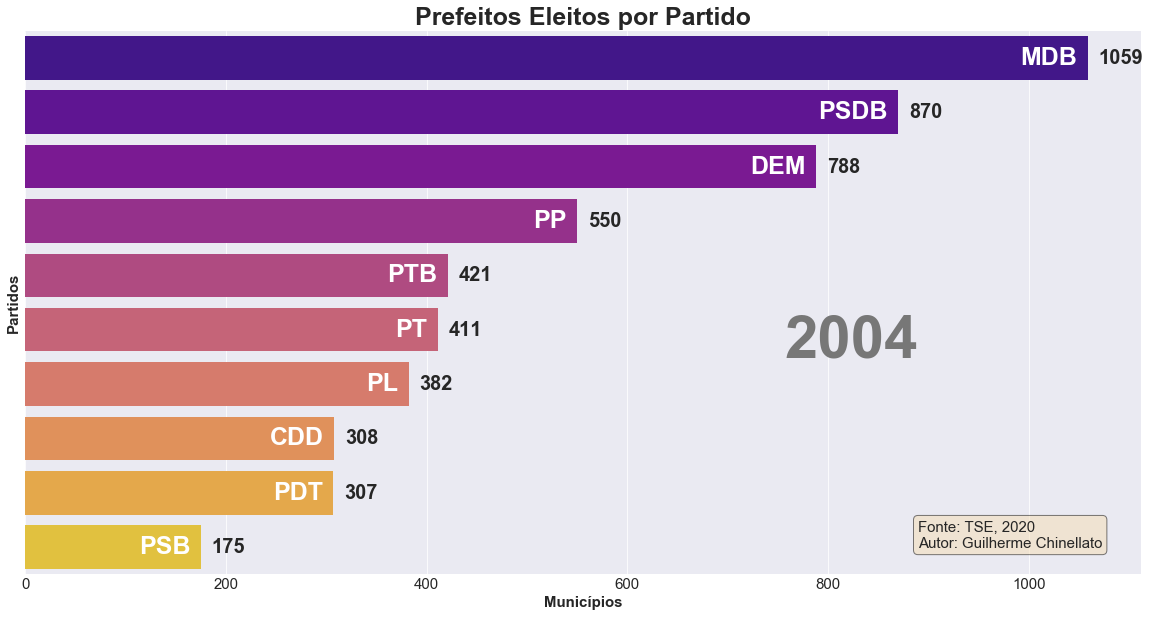

In [20]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize = (20,10))
title = 'Prefeitos Eleitos por Partido'
textstr = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))

animator = animation.FuncAnimation(fig, draw_barchart, frames=ano_da_eleicao, fargs=(res, ax, title, textstr), interval=2000)
HTML(animator.to_jshtml()) 

# Evolução de prefeitos eleitos por partidos (>200mil hab.)

In [21]:
sigla_estado = {'AC':'Acre',
                'AL':'Alagoas',
                'AP':'Amapa',
                'AM':'Amazonas',
                'BA':'Bahia',
                'CE':'Ceara',
                'DF':'Distrito Federal',
                'ES':'Espirito Santos',
                'GO':'Goias',
                'MA':'Maranhao',
                'MT':'Mato Grosso',
                'MS':'Mato Grosso do Sul',
                'MG':'Minas Gerais',
                'PA':'Para',
                'PB':'Paraiba',
                'PR':'Parana',
                'PE':'Pernambuco',
                'PI':'Piaui',
                'RJ':'Rio de Janeiro',
                'RN':'Rio Grande do Norte',
                'RS':'Rio Grande do Sul',
                'RO':'Rondonia',
                'RR':'Roraima',
                'SC':'Santa Catarina',
                'SP':'Sao Paulo',
                'SE':'Sergipe',
                'TO':'Tocantins'}

In [22]:
capitais = {'AC':'Rio Branco',
            'AL':'Maceio',
            'AP':'Macapa',
            'AM':'Manaus',
            'BA':'Salvador',
            'CE':'Fortaleza',
            'DF':'Brasilia',
            'ES':'Vitoria',
            'GO':'Goiania',
            'MA':'São Luis',
            'MT':'Cuiaba',
            'MS':'Campo Grande',
            'MG':'Belo Horizonte',
            'PA':'Belem',
            'PB':'Joao Pessoa',
            'PR':'Curitiba',
            'PE':'Recife',
            'PI':'Teresina',
            'RJ':'Rio de Janeiro',
            'RN':'Natal',
            'RS':'Porto Alegre',
            'RO':'Porto Velho',
            'RR':'Boa Vista',
            'SC':'Florianopolis',
            'SP':'Sao Paulo',
            'SE':'Aracaju',
            'TO':'Palmas'}

Obter lista da populacao por municipio

In [23]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o_(2020)'

In [24]:
municipio_pop = pd.read_html(url, thousands=' ')[0]

# eliminar espaço para converter para int
municipio_pop['População'] = municipio_pop['População'].str.replace('\D', '').astype(int)

# converter estado e municipio para sem acentos e maiusculo
municipio_pop['Unidade federativa'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: unidecode(x))
municipio_pop['Município'] = municipio_pop['Município'].str.upper().apply(lambda x: unidecode(x))

# abreviar UF
municipio_pop['sigla_uf'] = municipio_pop['Unidade federativa'].str.upper().apply(lambda x: [k for k, v in sigla_estado.items() if (unidecode(v.upper()) == x)])
municipio_pop = municipio_pop.explode('sigla_uf')

Filtrar somente municipios com mais de 200mil habitantes

In [25]:
# somente municipios com >200mil hab.
municipio_200mil = municipio_pop[municipio_pop['População'] > 200000].loc[:,['Município','sigla_uf','Unidade federativa']]

# eliminar brasilia
municipio_200mil = municipio_200mil.assign(nome_sigla_municipio = municipio_200mil.sigla_uf + ',' + municipio_200mil['Município'])
municipio_200mil.drop(municipio_200mil[municipio_200mil['Município'] == 'BRASILIA'].index, inplace=True)

# eliminar municipios que possuem o mesmo nome, mas são de diferentes estados e nao possuem +200mil.
df_temp = df.assign(nome_sigla_municipio = df.sigla_uf + ',' + df.nome_municipio)
df_200mil = df_temp[(df_temp.nome_sigla_municipio.isin(municipio_200mil.nome_sigla_municipio.tolist()))]

In [26]:
res_200mil = pd.DataFrame()
res_200mil = group_by_year(df_200mil)

Preparar dataset para flourish

In [27]:
res_200mil.insert(0, 'ideologia', res_200mil.index.map(mapa_ideologico))
res_200mil.to_excel('output/flourish_municipios_200mil.xlsx')

# Evolução de prefeitos eleitos por partidos (capitais)

In [28]:
# converter estado e municipio para sem acentos e maiusculo
capitais_upper = {k.upper() : unidecode(v.upper()) for k,v in capitais.items() }
del capitais_upper['DF']

# eliminar municipios que possuem o mesmo nome, mas são de diferentes estados
df_temp = df.assign(nome_sigla_municipio = df.sigla_uf + ',' + df.nome_municipio)

# somente municipios das capitais
lista_capitais = [ k + ',' + v for k,v in capitais_upper.items() ]
df_capitais = df_temp[(df_temp.nome_sigla_municipio.isin(lista_capitais))]

In [29]:
res_capitais = pd.DataFrame()
res_capitais = group_by_year(df_capitais)

Preparar dataset para flourish

In [30]:
res_capitais.insert(0, 'ideologia', res_capitais.index.map(mapa_ideologico))
res_capitais.to_excel('output/flourish_municipios_capitais.xlsx')

# Qual a tendência?

### Todos municípios

In [31]:
r_esq = res[res.ideologia == 'Esquerda']
r_esq = r_esq.drop('ideologia', axis=1).T
r_esq = r_esq.fillna(0).astype(int)
r_esq.sort_values(r_esq.index[-1], axis=1, ascending=False, inplace=True)

r_dir = res[res.ideologia == 'Direita']
r_dir = r_dir.drop('ideologia', axis=1).T
r_dir = r_dir.fillna(0).astype(int)
r_dir.sort_values(r_dir.index[-1], axis=1, ascending=False, inplace=True)

r_centro_dem = res[res.ideologia == 'Centro Dem']
r_centro_dem = r_centro_dem.drop('ideologia', axis=1).T
r_centro_dem = r_centro_dem.fillna(0).astype(int)
r_centro_dem.sort_values(r_centro_dem.index[-1], axis=1, ascending=False, inplace=True)

r_centrao = res[res.ideologia == 'Centrao']
r_centrao = r_centrao.drop('ideologia', axis=1).T
r_centrao = r_centrao.fillna(0).astype(int)
r_centrao.sort_values(r_centrao.index[-1], axis=1, ascending=False, inplace=True)

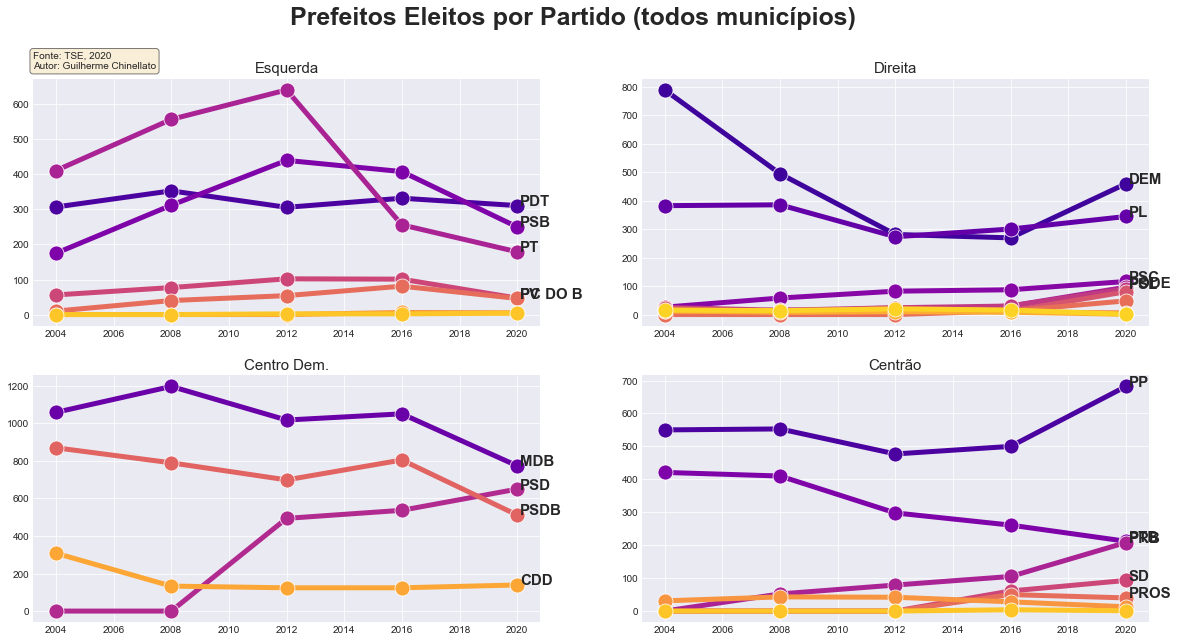

In [32]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
title = 'Prefeitos Eleitos por Partido (todos municípios)'
legend = '\n'.join((
    r'Fonte: TSE, 2020',
    r'Autor: Guilherme Chinellato'
))
draw_subplots(fig, axs, r_esq, r_dir, r_centro_dem, r_centrao, title, legend)      
plt.savefig('output/prefeitos_partido_total.png',dpi=300, bbox_inches = 'tight')

Resultado agregado

In [33]:
agg_total = pd.DataFrame(columns=['Esquerda','Direita','Centro Dem.','Centrão'], index=ano_da_eleicao)
for k,v in enumerate(r_esq.index):
    agg_total.loc[v,'Esquerda'] = r_esq.loc[v].sum()
    
for k,v in enumerate(r_dir.index):
    agg_total.loc[v,'Direita'] = r_dir.loc[v].sum()
    
for k,v in enumerate(r_centro_dem.index):
    agg_total.loc[v,'Centro Dem.'] = r_centro_dem.loc[v].sum()
    
for k,v in enumerate(r_centrao.index):
    agg_total.loc[v,'Centrão'] = r_centrao.loc[v].sum()

In [34]:
agg_total

,Esquerda,Direita,Centro Dem.,Centrão
2004,959,1290,2237,1002
2008,1339,1010,2120,1058
2012,1545,743,2335,896
2016,1186,774,2517,1009
2020,842,1241,2075,1249


In [35]:
agg_total_var = agg_total.pct_change().stack().reset_index()
agg_total_var.columns = ['Ano','Ideologia', 'Variação']
agg_total.pct_change()

,Esquerda,Direita,Centro Dem.,Centrão
2004,NaN,NaN,NaN,NaN
2008,0.396246,-0.217054,-0.052302,0.055888
2012,0.153846,-0.264356,0.101415,-0.153119
2016,-0.232362,0.041723,0.077944,0.126116
2020,-0.290051,0.603359,-0.175606,0.237859


### Municípios >200mil habitantes

In [36]:
r_esq_200mil = res_200mil[res_200mil.ideologia == 'Esquerda']
r_esq_200mil = r_esq_200mil.drop('ideologia', axis=1).T
r_esq_200mil = r_esq_200mil.fillna(0).astype(int)
r_esq_200mil.sort_values(r_esq_200mil.index[-1], axis=1, ascending=False, inplace=True)

r_dir_200mil = res_200mil[res_200mil.ideologia == 'Direita']
r_dir_200mil = r_dir_200mil.drop('ideologia', axis=1).T
r_dir_200mil = r_dir_200mil.fillna(0).astype(int)
r_dir_200mil.sort_values(r_dir_200mil.index[-1], axis=1, ascending=False, inplace=True)

r_centro_dem_200mil = res_200mil[res_200mil.ideologia == 'Centro Dem']
r_centro_dem_200mil = r_centro_dem_200mil.drop('ideologia', axis=1).T
r_centro_dem_200mil = r_centro_dem_200mil.fillna(0).astype(int)
r_centro_dem_200mil.sort_values(r_centro_dem_200mil.index[-1], axis=1, ascending=False, inplace=True)

r_centrao_200mil = res_200mil[res_200mil.ideologia == 'Centrao']
r_centrao_200mil = r_centrao_200mil.drop('ideologia', axis=1).T
r_centrao_200mil = r_centrao_200mil.fillna(0).astype(int)
r_centrao_200mil.sort_values(r_centrao_200mil.index[-1], axis=1, ascending=False, inplace=True)

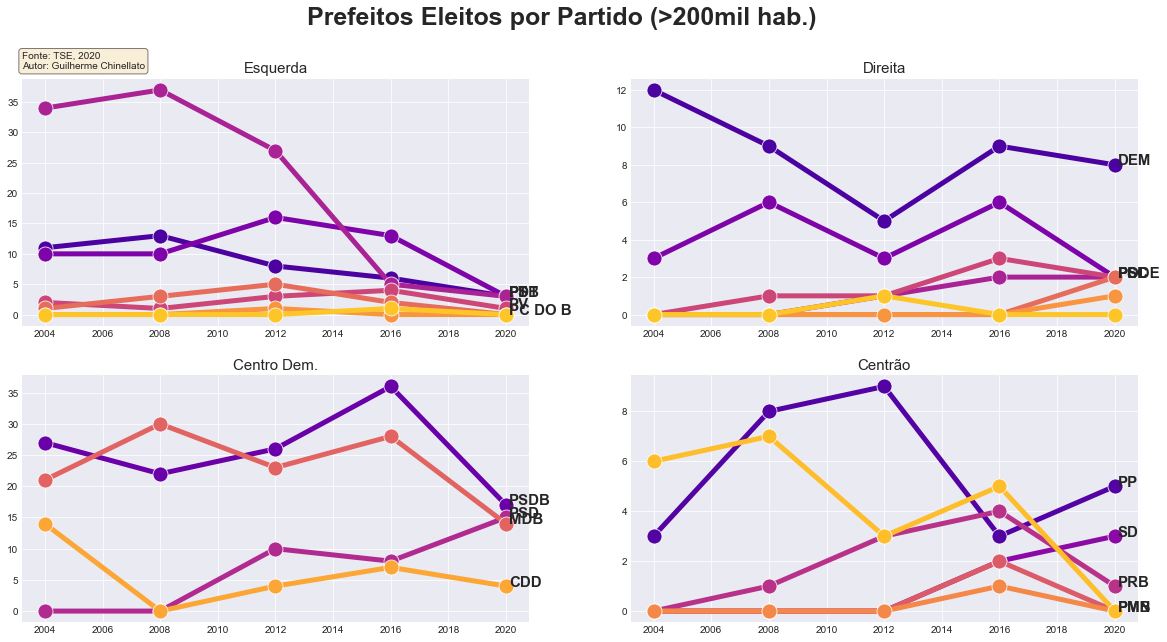

In [37]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
title = 'Prefeitos Eleitos por Partido (>200mil hab.)'
draw_subplots(fig, axs, r_esq_200mil, r_dir_200mil, r_centro_dem_200mil, r_centrao_200mil, title, legend)      
plt.savefig('output/prefeitos_partido_200mil.png',dpi=300, bbox_inches = 'tight')

In [38]:
agg_200mil = pd.DataFrame(columns=['Esquerda','Direita','Centro Dem.','Centrão'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_200mil.index):
    agg_200mil.loc[v,'Esquerda'] = r_esq_200mil.loc[v].sum()
    
for k,v in enumerate(r_dir_200mil.index):
    agg_200mil.loc[v,'Direita'] = r_dir_200mil.loc[v].sum()
    
for k,v in enumerate(r_centro_dem_200mil.index):
    agg_200mil.loc[v,'Centro Dem.'] = r_centro_dem_200mil.loc[v].sum()
    
for k,v in enumerate(r_centrao_200mil.index):
    agg_200mil.loc[v,'Centrão'] = r_centrao_200mil.loc[v].sum()

In [39]:
agg_200mil

,Esquerda,Direita,Centro Dem.,Centrão
2004,58,15,62,9
2008,64,16,52,16
2012,60,11,63,15
2016,31,20,79,17
2020,10,17,50,9


In [40]:
agg_200mil_var = agg_200mil.pct_change().stack().reset_index()
agg_200mil_var.columns = ['Ano','Ideologia', 'Variação']
agg_200mil.pct_change()

,Esquerda,Direita,Centro Dem.,Centrão
2004,NaN,NaN,NaN,NaN
2008,0.103448,0.066667,-0.161290,0.777778
2012,-0.062500,-0.312500,0.211538,-0.062500
2016,-0.483333,0.818182,0.253968,0.133333
2020,-0.677419,-0.150000,-0.367089,-0.470588


### Capitais

In [41]:
r_esq_capitais = res_capitais[res_capitais.ideologia == 'Esquerda']
r_esq_capitais = r_esq_capitais.drop('ideologia', axis=1).T
r_esq_capitais = r_esq_capitais.fillna(0).astype(int)
r_esq_capitais.sort_values(r_esq_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_dir_capitais = res_capitais[res_capitais.ideologia == 'Direita']
r_dir_capitais = r_dir_capitais.drop('ideologia', axis=1).T
r_dir_capitais = r_dir_capitais.fillna(0).astype(int)
r_dir_capitais.sort_values(r_dir_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_centro_capitais = res_capitais[res_capitais.ideologia == 'Centro Dem']
r_centro_capitais = r_centro_capitais.drop('ideologia', axis=1).T
r_centro_capitais = r_centro_capitais.fillna(0).astype(int)
r_centro_capitais.sort_values(r_centro_capitais.index[-1], axis=1, ascending=False, inplace=True)

r_centrao_capitais = res_capitais[res_capitais.ideologia == 'Centrao']
r_centrao_capitais = r_centrao_capitais.drop('ideologia', axis=1).T
r_centrao_capitais = r_centrao_capitais.fillna(0).astype(int)
r_centrao_capitais.sort_values(r_centrao_capitais.index[-1], axis=1, ascending=False, inplace=True)

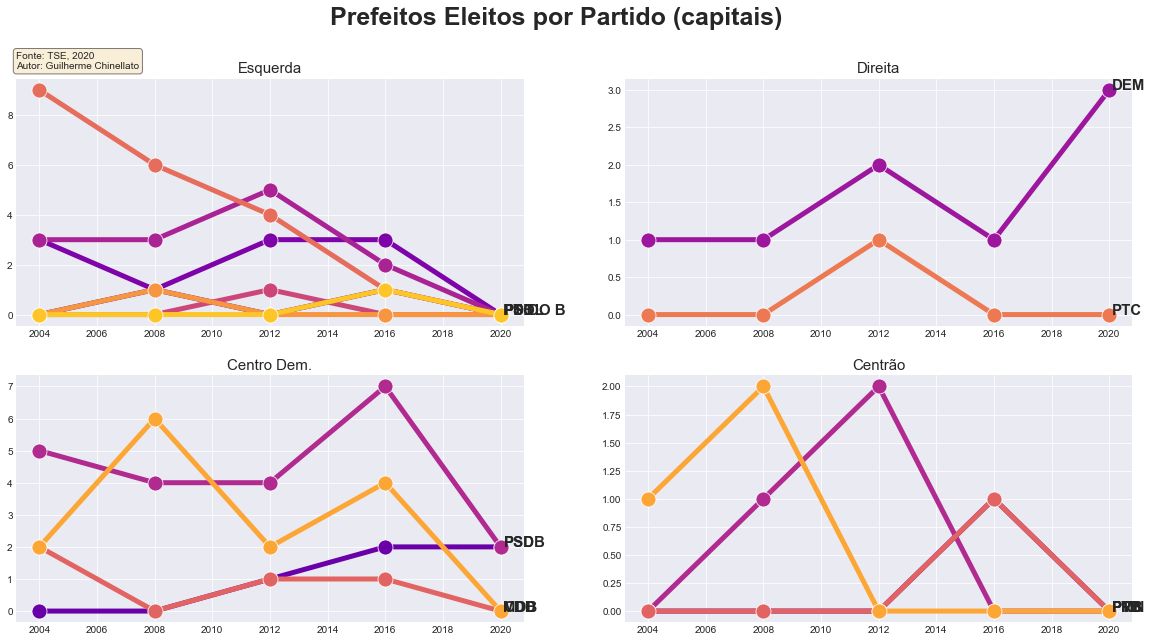

In [42]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
title = 'Prefeitos Eleitos por Partido (capitais)'
draw_subplots(fig, axs, r_esq_capitais, r_dir_capitais, r_centro_capitais, r_centrao_capitais, title, legend)      
plt.savefig('output/prefeitos_partido_capitais.png',dpi=300, bbox_inches = 'tight')

Resultado agregado

In [43]:
agg_capitais = pd.DataFrame(columns=['Esquerda','Direita','Centro Dem.','Centrão'], index=ano_da_eleicao)
for k,v in enumerate(r_esq_capitais.index):
    agg_capitais.loc[v,'Esquerda'] = r_esq_capitais.loc[v].sum()
    
for k,v in enumerate(r_dir_capitais.index):
    agg_capitais.loc[v,'Direita'] = r_dir_capitais.loc[v].sum()
    
for k,v in enumerate(r_centro_capitais.index):
    agg_capitais.loc[v,'Centro Dem.'] = r_centro_capitais.loc[v].sum()
    
for k,v in enumerate(r_centrao_capitais.index):
    agg_capitais.loc[v,'Centrão'] = r_centrao_capitais.loc[v].sum()

In [44]:
agg_capitais

,Esquerda,Direita,Centro Dem.,Centrão
2004,15,1,9,1
2008,12,1,10,3
2012,13,3,8,2
2016,8,1,14,2
2020,0,3,4,0


In [45]:
agg_capitais_var = agg_capitais.pct_change().stack().reset_index()
agg_capitais_var.columns = ['Ano','Ideologia', 'Variação']
agg_capitais.pct_change()

,Esquerda,Direita,Centro Dem.,Centrão
2004,NaN,NaN,NaN,NaN
2008,-0.200000,0.000000,0.111111,2.000000
2012,0.083333,2.000000,-0.200000,-0.333333
2016,-0.384615,-0.666667,0.750000,0.000000
2020,-1.000000,2.000000,-0.714286,-1.000000


# Conclusão

Correlação das ideologias entre:
- Todos municípios vs Municípios >200mil hab.
- Todos municípios vs Capitais
- Municípios >200mil hab. vs Capitais

In [46]:
corr = pd.DataFrame()
corr['Total/200mil'] = agg_total.corrwith(agg_200mil, axis=0)
corr['Total/Capitais'] = agg_total.corrwith(agg_capitais, axis=0)
corr['200mil/Capitais'] = agg_200mil.corrwith(agg_capitais, axis=0)

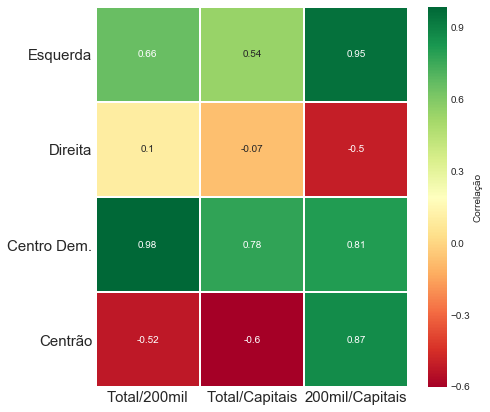

In [47]:
fig, ax = plt.subplots( figsize = (7,7))

hm = sns.heatmap(corr, cmap='RdYlGn', ax=ax, linewidths=1,
                 cbar_kws={'label': 'Correlação', 'orientation': 'vertical'},
                 annot=True, xticklabels=True, yticklabels=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

hm.set_xticklabels(hm.get_xticklabels(), rotation=0, fontsize=15)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize=15)
plt.savefig('output/correl.png',dpi=300, bbox_inches = 'tight')

Normalizar dados

In [48]:
df_merge = pd.merge(agg_total.stack().reset_index(), agg_200mil.stack().reset_index(), how='left', on=['level_0', 'level_1'])
df_merge = pd.merge(df_merge, agg_capitais.stack().reset_index(), how='left', on=['level_0', 'level_1'])
df_merge.columns = ['Ano','Ideologia', 'Total', '200mil', 'Capitais']

In [49]:
#d = df_merge.loc[:,'Total']
#df_merge['Total_norm'] = (d-d.min())/(d.max()-d.min())

#d = df_merge.loc[:,'200mil']
#df_merge['200mil_norm'] = (d-d.min())/(d.max()-d.min())

#d = df_merge.loc[:,'Capitais']
#df_merge['Capitais_norm'] = (d-d.min())/(d.max()-d.min())

Pairplot

C:\Users\guilh\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


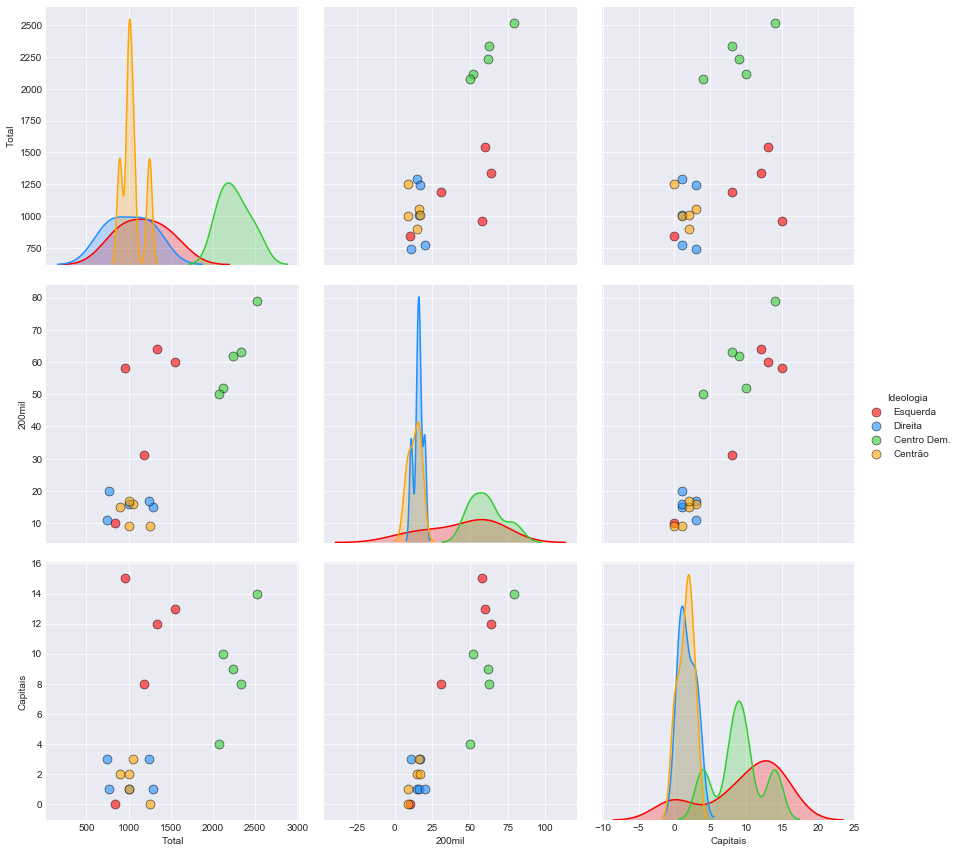

In [50]:
colors = ['red', 'dodgerblue', 'limegreen', 'orange']
pp = sns.pairplot(df_merge.drop('Ano',axis=1), hue='Ideologia', kind='scatter', size=4, palette=colors,
                  plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

#plt.suptitle('Prefeito Eleitos por Tamanho do Município', size=20, fontweight='bold');
plt.savefig('output/pairplot.png',dpi=300, bbox_inches = 'tight')

Tendência agregada

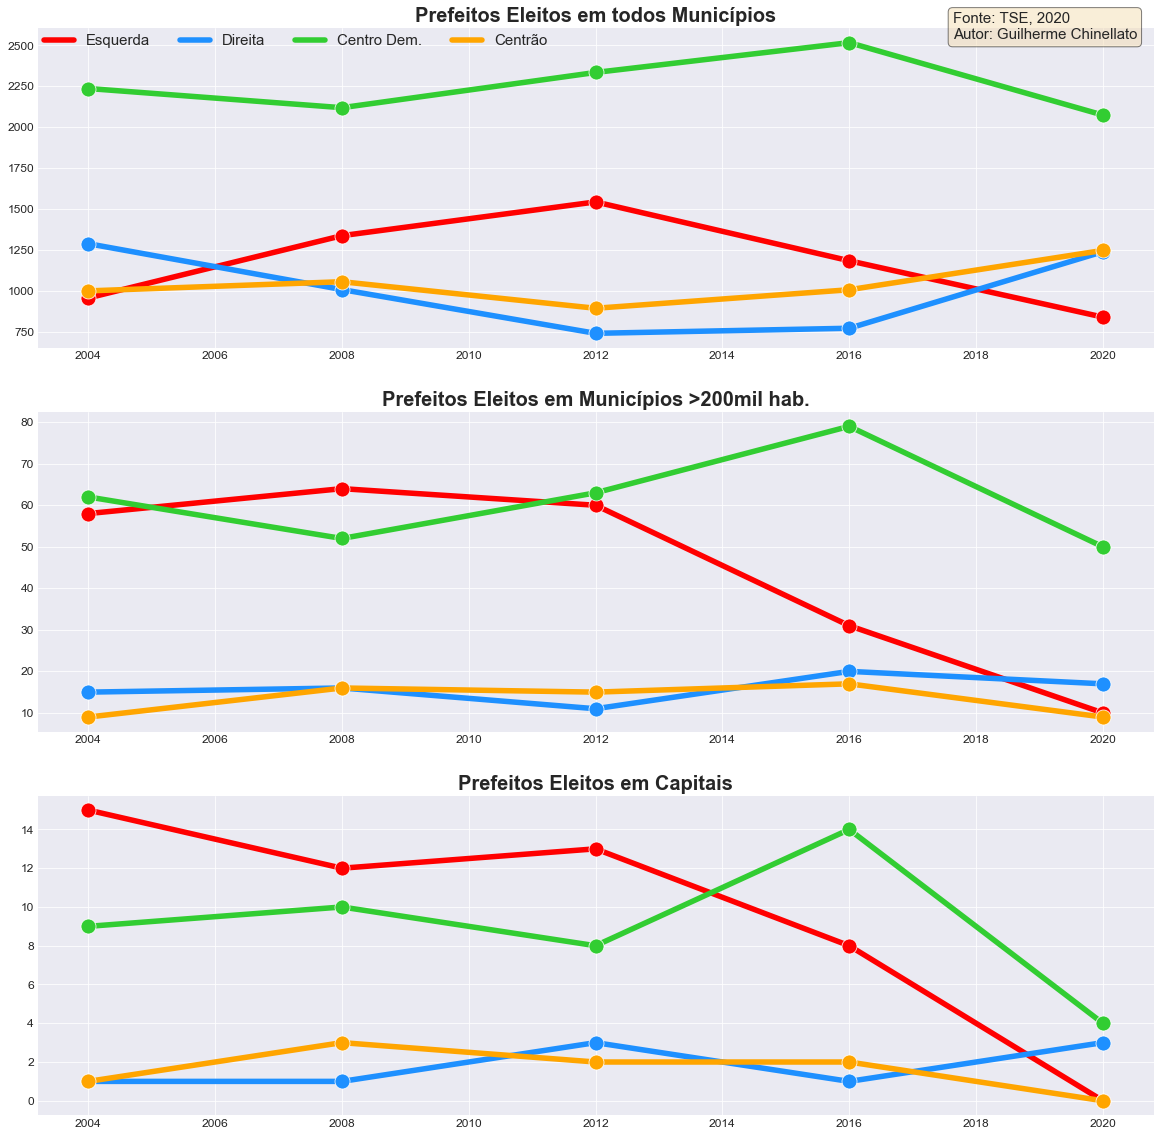

In [51]:
fig, axs = plt.subplots(3,1, figsize = (20,20))

l_total = sns.lineplot(data=agg_total, dashes=False, legend='brief', linewidth=5.5, palette=colors, marker='o', markersize=15, ax=axs[0])
l_200mil = sns.lineplot(data=agg_200mil, dashes=False, legend=False, linewidth=5.5, palette=colors, marker='o', markersize=15, ax=axs[1])
l_capitais = sns.lineplot(data=agg_capitais, dashes=False, legend=False, linewidth=5.5, palette=colors, marker='o', markersize=15, ax=axs[2])

axs[0].set_title('Prefeitos Eleitos em todos Municípios', fontsize=20, fontweight='bold')
axs[1].set_title('Prefeitos Eleitos em Municípios >200mil hab.', fontsize=20, fontweight='bold')
axs[2].set_title('Prefeitos Eleitos em Capitais', fontsize=20, fontweight='bold')

axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

handles, labels = axs[0].get_legend_handles_labels()
leg = l_total.legend(flip(handles, 4), flip(labels, 4), loc=2, ncol=4, fontsize=15,borderaxespad=0.)    
for line in leg.get_lines():
    line.set_linewidth(5.5)
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.82, 1.05, textstr, transform=axs[0].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
plt.savefig('output/prefeitos_consolidado_agg.png',dpi=300, bbox_inches = 'tight')

Variação entre eleições

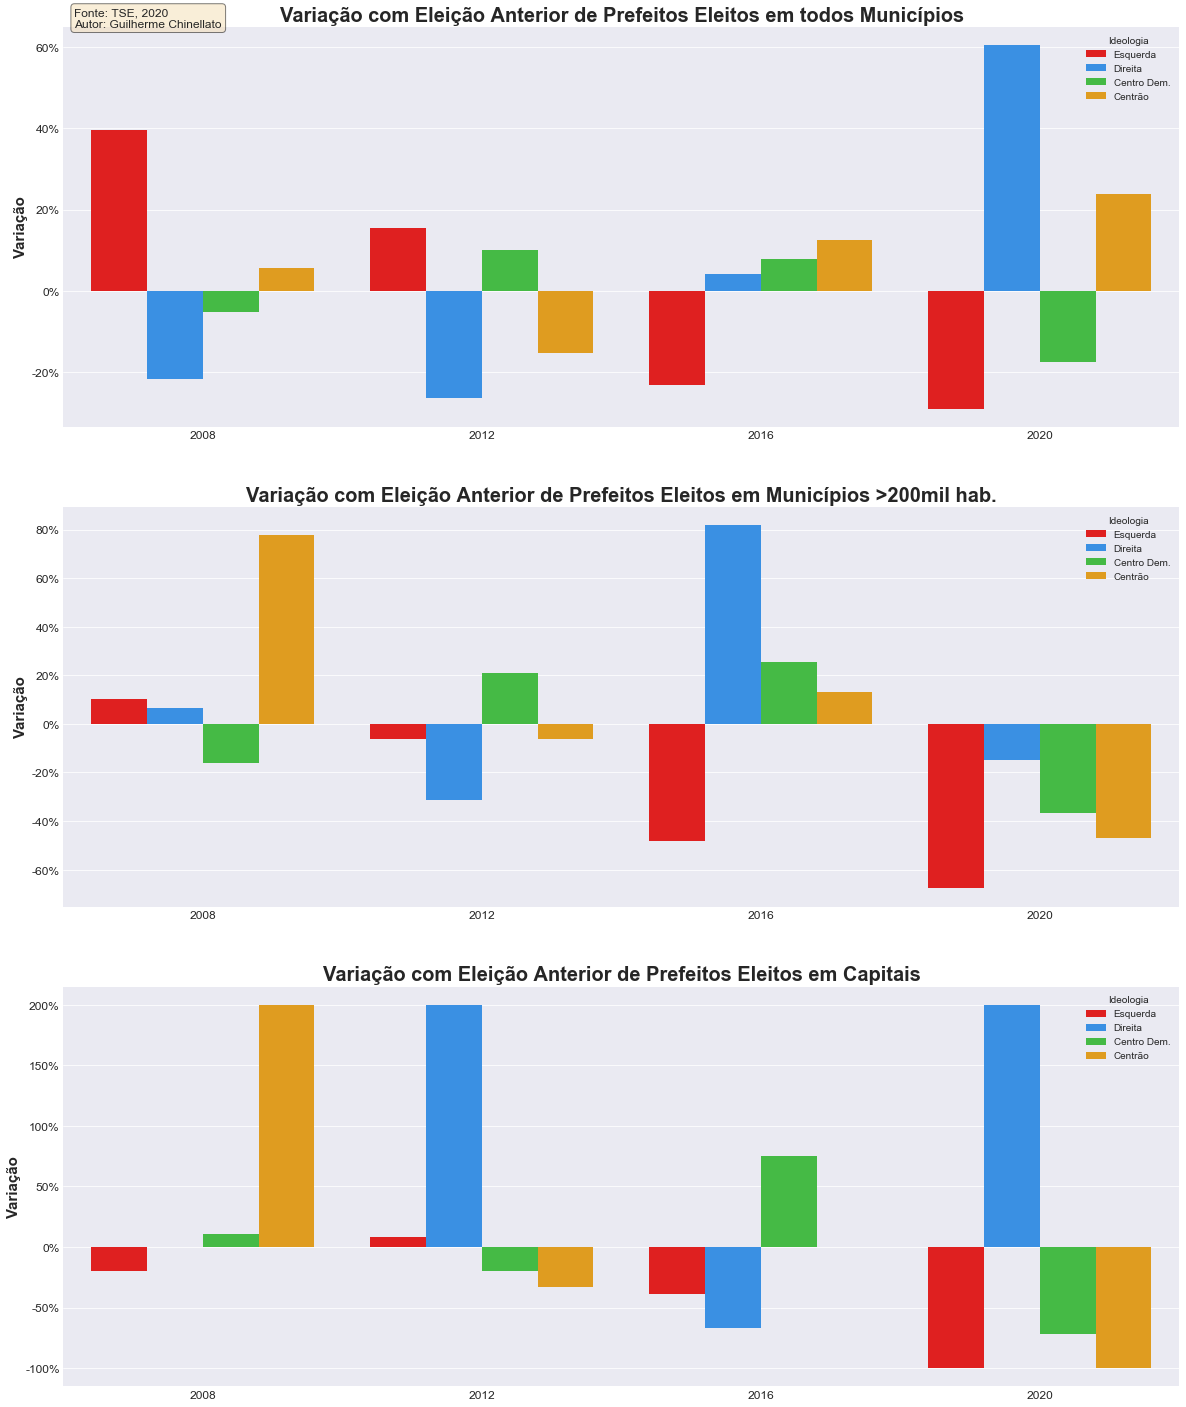

In [52]:
fig, axs = plt.subplots(3,1, figsize = (20,25))

c_total = sns.catplot(data=agg_total_var, x='Ano', y='Variação', hue='Ideologia', kind='bar', palette=colors, ax=axs[0])
c_200mil = sns.catplot(data=agg_200mil_var, x='Ano', y='Variação', hue='Ideologia', kind='bar', palette=colors, ax=axs[1])
c_capitais = sns.catplot(data=agg_capitais_var, x='Ano', y='Variação', hue='Ideologia', kind='bar', palette=colors, ax=axs[2])

axs[0].set_title('Variação com Eleição Anterior de Prefeitos Eleitos em todos Municípios', fontsize=20, fontweight='bold')
axs[1].set_title('Variação com Eleição Anterior de Prefeitos Eleitos em Municípios >200mil hab.', fontsize=20, fontweight='bold')
axs[2].set_title('Variação com Eleição Anterior de Prefeitos Eleitos em Capitais', fontsize=20, fontweight='bold')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')

axs[0].set_ylabel('Variação', fontsize=15, fontweight='bold')
axs[1].set_ylabel('Variação', fontsize=15, fontweight='bold')
axs[2].set_ylabel('Variação', fontsize=15, fontweight='bold')

axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
vals = axs[2].get_yticks()
axs[2].set_yticklabels(['{:,.0%}'.format(x) for x in vals])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0].text(0.01, 1.05, textstr, transform=axs[0].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.close(2)
plt.close(3)
plt.close(4)
plt.savefig('output/prefeitos_consolidado_agg_var.png',dpi=300, bbox_inches = 'tight')

Observando o gráfico de tendência dividido por ideologia é possível observar que não existe uma grande diferença no comportamento de voto por determinada ideologia. 


Por exemplo, os partidos de **esquerda** estão em baixa desde 2012, tanto no conjunto total de municípios, municípios >200mil e em capitais. 
Da mesma forma que o **centro democrático** se manteve estável ao longo do tempo nos três cenários, mas em 2020 perdeu espaço para partidos de **direita** e **centrão**.


O gráfico de variação deixa evidente que não existe um padrão constante, entre a eleição de 2008 o mesmo movimento é similar nos três cenários, porém na eleição de 2012, a *direita* ganha muita força nas capitais e perde nas cidades menores, <ins>anulando a hipótese de que grande centros são mais *progressistas*</ins>. As grandes cidades respondem de forma muita agressiva manifestações nacionais, independente da ideologia, movimento que só acontece nos municípios menores na próxima eleição, como em 2016.


A movimentação dos partidos de **esquerda** tem forte correleção nos três cenários. A ascensão da **esquerda** é refletida simultaneamente nas capitais e municípios menores. O **centro democrático** apresenta o mesmo comportamento.

Porém, a **direita** possui correlação neutra nos três cenários, não sendo possível determinar um padrão de ascensão ou declínio entre grandes centros e cidades menores.

Já o **centrão** aprensa correlação negativa entre o total de municípios e municípios >200mil hab., indicando que quando o **centrão** se fortalece nas cidades menores, se enfraquece nas cidades grandes, mas quando se fortalece em municípios >200mil hab., também se fortalece nas capitais.


# TO DO

Mapa de calor do Brasil com quantidade de votos em prefeitos com determinada ideologia do partido